In [13]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models  # Add models here
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import confusion_matrix
from skimage import feature, data
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import exposure, color

Epoch 1/30
250/250 [==============================] - 27s 100ms/step - loss: 2.6981 - accuracy: 0.1968 - val_loss: 2.3980 - val_accuracy: 0.1055 - lr: 9.0000e-05
Epoch 2/30
250/250 [==============================] - 24s 97ms/step - loss: 2.2875 - accuracy: 0.2530 - val_loss: 2.8939 - val_accuracy: 0.1155 - lr: 9.0000e-05
Epoch 3/30
250/250 [==============================] - 26s 102ms/step - loss: 2.0832 - accuracy: 0.2906 - val_loss: 1.9025 - val_accuracy: 0.2540 - lr: 9.0000e-05
Epoch 4/30
250/250 [==============================] - 27s 107ms/step - loss: 1.9553 - accuracy: 0.2996 - val_loss: 1.9929 - val_accuracy: 0.3350 - lr: 9.0000e-05
Epoch 5/30
250/250 [==============================] - 25s 99ms/step - loss: 1.8570 - accuracy: 0.3288 - val_loss: 1.6250 - val_accuracy: 0.4085 - lr: 9.0000e-05
Epoch 6/30
250/250 [==============================] - 24s 98ms/step - loss: 1.7865 - accuracy: 0.3516 - val_loss: 4.2075 - val_accuracy: 0.1950 - lr: 8.1000e-05
Epoch 7/30
250/250 [===========

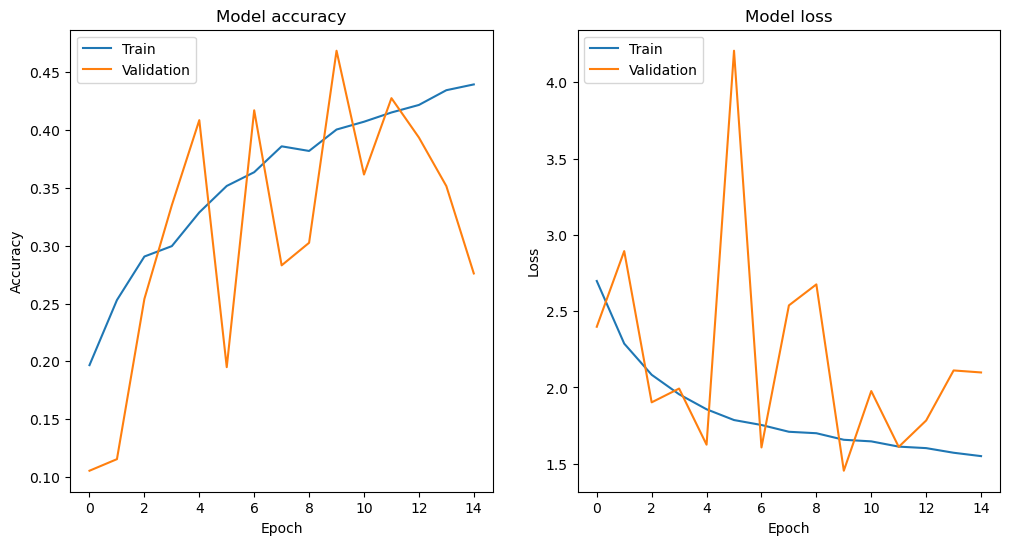

32/32 [==============================] - 1s 20ms/step - loss: 1.4642 - accuracy: 0.4780
Test Accuracy: 47.80%


In [15]:
# Load data files
trnImage_normalized = np.transpose(np.load('trnImage.npy'), (3, 0, 1, 2))
tstImage_normalized = np.load('tstImage.npy')
trnLabel_fine = np.load('trnLabel.npy')
tstLabel_fine = np.load('tstLabel.npy')




# Load label files
coarse_labels = pd.read_csv('coarse_labels.csv')

fine_labels = pd.read_csv('fine_labels.csv', header=None, index_col=0)


# Data preprocessing
trnImage_normalized = trnImage_normalized / 255.0
tstImage_normalized = tstImage_normalized / 255.0

# Convert labels to one-hot encoding for training data
num_classes_fine = len(np.unique(trnLabel_fine))
trnLabel_fine_one_hot = to_categorical(trnLabel_fine, num_classes=num_classes_fine)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    trnImage_normalized, trnLabel_fine_one_hot, test_size=0.2, random_state=42
)

# Create an image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the data generator on your training data
datagen.fit(X_train)



# Define a more complex CNN model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes_fine, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Introduce early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Learning rate scheduler
def lr_schedule(epoch, lr):
    return lr * 0.9 if epoch % 5 == 0 else lr

lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)

# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])






# Flatten tstLabel_fine
tstLabel_fine = tstLabel_fine.flatten()

# Reshape tstImage_normalized for evaluation
tstImage_eval = np.transpose(tstImage_normalized, (3, 0, 1, 2))




# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(tstImage_eval, to_categorical(tstLabel_fine, num_classes=num_classes_fine))
print("Test Accuracy: {:.2%}".format(test_acc))

32/32 [==============================] - 1s 19ms/step


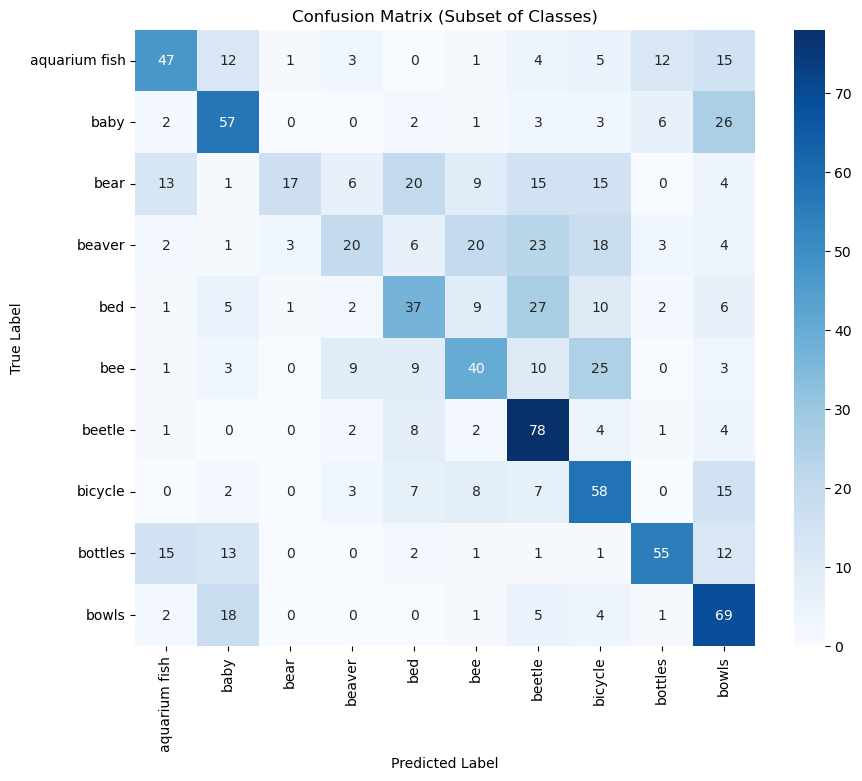

In [18]:

# Evaluate the model on the test set
y_pred = np.argmax(model.predict(tstImage_eval), axis=1)

# Ensure tstLabel_fine is not flattened and not one-hot encoded
y_true = tstLabel_fine


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Choose a subset of classes to display in the confusion matrix (e.g., first 10 classes)
subset_classes = range(10)

# Plot confusion matrix for the subset of classes
plt.figure(figsize=(10, 8))
sns.heatmap(cm[np.ix_(subset_classes, subset_classes)], annot=True, fmt="d", cmap="Blues",
            xticklabels=fine_labels.values.flatten()[subset_classes],
            yticklabels=fine_labels.values.flatten()[subset_classes])
plt.title('Confusion Matrix (Subset of Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



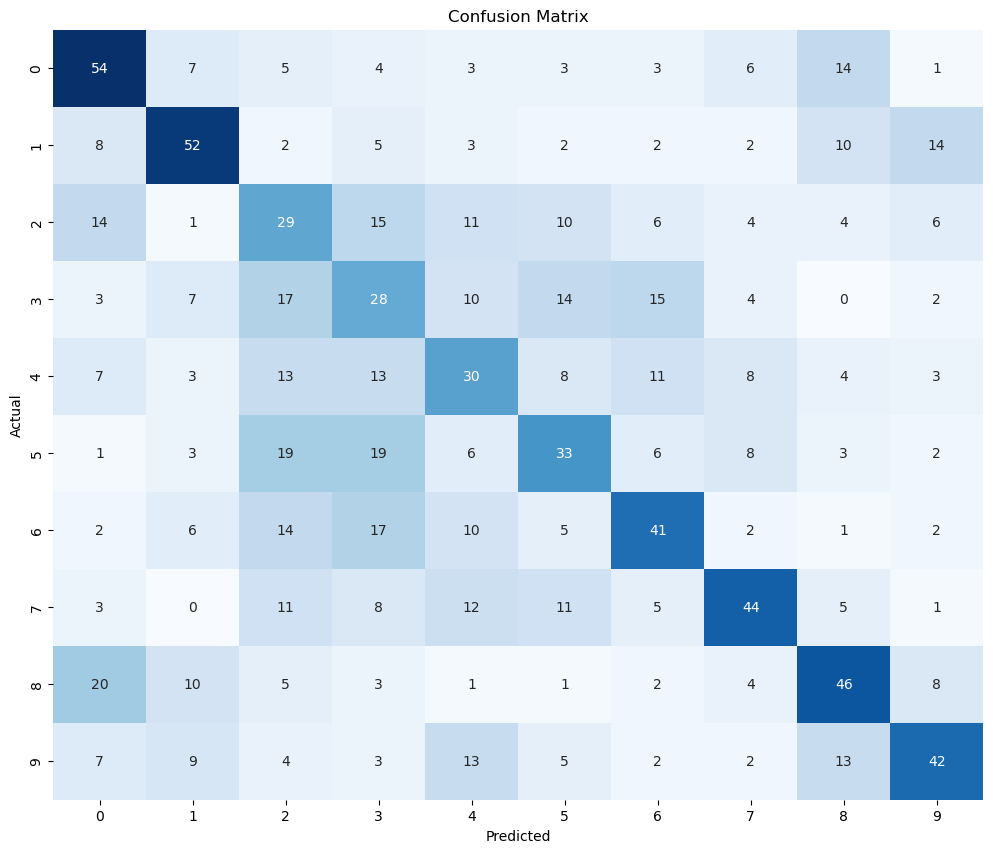

Overall Accuracy: 39.90%
Category-wise Accuracy:
Category 0: 54.00%
Category 1: 52.00%
Category 2: 29.00%
Category 3: 28.00%
Category 4: 30.00%
Category 5: 33.00%
Category 6: 41.00%
Category 7: 44.00%
Category 8: 46.00%
Category 9: 42.00%


In [1]:


# Load data
train_images_data = np.load('trnImage.npy')
test_images_data = np.load('tstImage.npy')
train_labels_data = np.load('trnLabel.npy')
test_labels_data = np.load('tstLabel.npy')

# Reshape the images to (10000, 32, 3)
train_images_data = np.transpose(train_images_data, (3, 0, 1, 2))
test_images_data = np.transpose(test_images_data, (3, 0, 1, 2))

# Convert images to grayscale
X_train_gray = np.array([color.rgb2gray(image) for image in train_images_data])
X_test_gray = np.array([color.rgb2gray(image) for image in test_images_data])

# Apply HOG feature extraction
def apply_hog(image):
    features, hog_image = hog(image, pixels_per_cell=(2, 2), cells_per_block=(3, 3), visualize=True)
    return features

X_train_hog = np.array([apply_hog(image) for image in X_train_gray])
X_test_hog = np.array([apply_hog(image) for image in X_test_gray])

# Reshape the labels to match the number of samples in the image data
y_train = train_labels_data.flatten()
y_test = test_labels_data.flatten()

# Initialize and train the SVM model
svm_model = SVC(kernel='linear')  
svm_model.fit(X_train_hog, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_hog)

# Calculate accuracy for each category
category_accuracies = []
for category in np.unique(y_test):
    category_indices = np.where(y_test == category)[0]
    correct_predictions = np.sum(y_pred[category_indices] == y_test[category_indices])
    total_samples = len(category_indices)
    accuracy = correct_predictions / total_samples * 100
    category_accuracies.append(accuracy)

# Report the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred) * 100

# Print results
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print("Category-wise Accuracy:")
for category, accuracy in zip(np.unique(y_test), category_accuracies):
    print(f"Category {category}: {accuracy:.2f}%")

